# XGBoost model

##  Read cleaned data from pickle 

Preprocessing applied to all files:
- Features with > 90% data missing or > 90% data with the same value were dropped
- If possible, categorical variables with 100s of categories were mapped to coaser categoricals
- Correlation plot analysis done on "V" columns and columns were dropped reduce collinearlity
	- https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
- Some "D" columns were normalized for time
- Aggregate features were added using "magic" technique
	- https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600#How-the-Magic-Works
- Dropped TransactionID and TransactionDT

In [61]:
import pickle
import glob
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
glob.glob('./data/clean_data/*')

['./data/clean_data/XGBoost_test_X_2.pkl',
 './data/clean_data/XGBoost_test_X_1.pkl',
 './data/clean_data/XGBoost_train_X_2.pkl',
 './data/clean_data/train_y.pkl',
 './data/clean_data/XGBoost_train_X_1.pkl',
 './data/clean_data/readmefirst.md']

In [3]:
'''X (version 1)
- Full 200 features
- Dummies created
'''
X_test_1 = pickle.load(open('./data/clean_data/XGBoost_test_X_1.pkl', 'rb'))
X_train_1 = pickle.load(open('./data/clean_data/XGBoost_train_X_1.pkl', 'rb'))

'''
X (version 2)
- Removed additional features
    - Highly correlated "C", "D" features
    - Removed features Chris (1st place winners) removed
    - Removed caterogical features withh 200+ categories even after 1)
- Dummies created
'''
X_test_2 = pickle.load(open('./data/clean_data/XGBoost_test_X_2.pkl', 'rb'))
X_train_2 = pickle.load(open('./data/clean_data/XGBoost_train_X_2.pkl', 'rb'))

y = pickle.load(open('./data/clean_data/train_y.pkl', 'rb'))

In [4]:
X_train_1.shape, X_train_2.shape, X_test_1.shape, X_test_2.shape, y.shape

((590540, 1323), (590540, 1303), (506691, 1573), (506691, 1553), (590540,))

## Develop a base XGB model

In [5]:
!pip install xgboost

In [6]:
from sklearn.model_selection import train_test_split, cross_validate,\
KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import xgboost as xgb
from sklearn.metrics import make_scorer

#### Since xgboost takes a considerable amount of time to run on non-GPU device, the following is a train-test split setup to assist with early stage coding/ debugging.

In [50]:
%%time
seed = 123
test_size = 0.3
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y, test_size = test_size, random_state = seed)

CPU times: user 3.63 s, sys: 2.5 s, total: 6.13 s
Wall time: 7.11 s


In [51]:
%%time
base_x1_model = xgb.XGBClassifier(eval_metric='auc', tree_method='hist')
base_x1_model.fit(X_train, y_train)
print("basic model is fitted")

basic model is fitted


In [56]:
%%time
base_x1_y_pred = base_x1_model.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, base_x1_y_pred)
print(f"ROC_AUC score: {auc_score* 100:.2f}%")
base_x1_frp, base_x1_tpr, _ = roc_curve(y_val, base_x1_y_pred)

ROC_AUC score: 95.32%
CPU times: user 8.12 s, sys: 2.78 s, total: 10.9 s
Wall time: 11.1 s


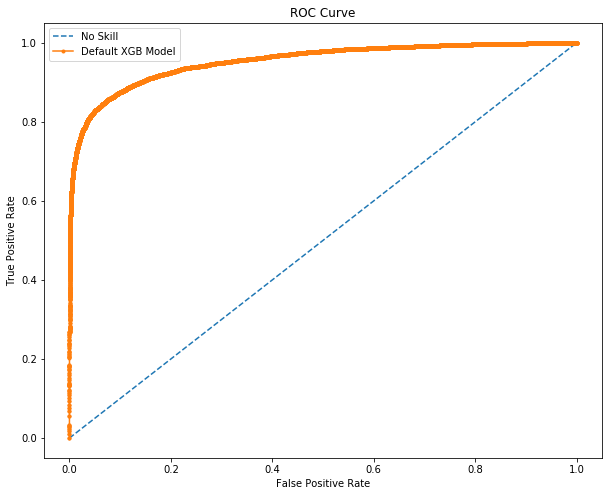

In [59]:
# Define true-positive and false-positive for no skill predictions
no_skill_pred = [0 for _ in range(len(y_val))]
ns_frp, ns_tpr, _ = roc_curve(y_val, no_skill_pred)

# Plot ROC curve across models
plt.figure(figsize=(10, 8))
plt.plot(ns_frp, ns_tpr, linestyle = '--', label='No Skill')
plt.plot(base_x1_frp, base_x1_tpr, marker = '.', label='Default XGB Model')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

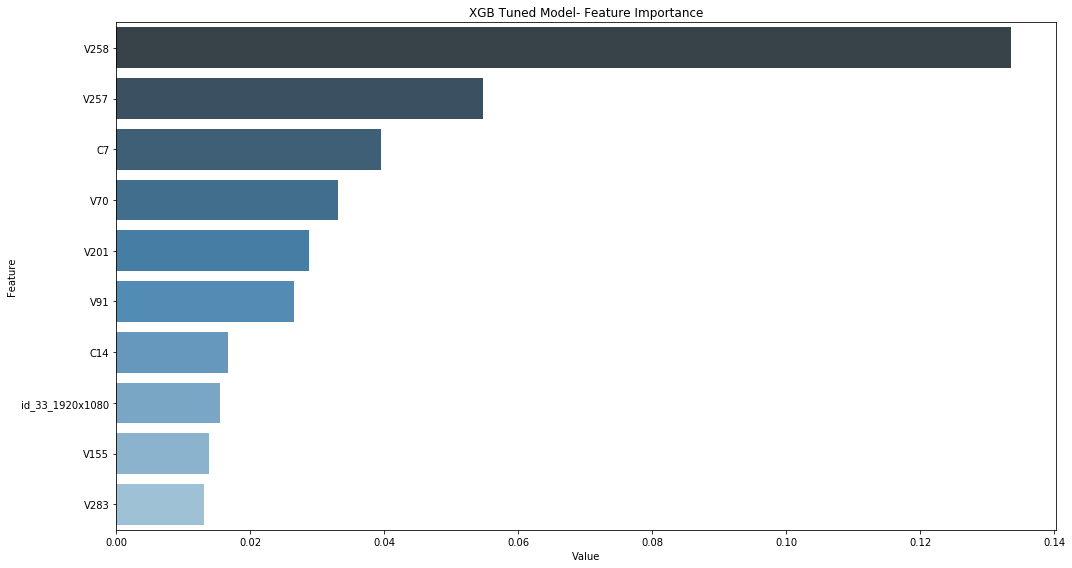

CPU times: user 245 ms, sys: 7.69 ms, total: 253 ms
Wall time: 259 ms


In [62]:
%%time
# Understand feature importance in the model
feature_imp = pd.DataFrame(sorted(zip(base_x1_model.feature_importances_,X_train_1.columns)), columns=['Value','Feature'])
plt.figure(figsize=(15, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:10],\
            palette = "Blues_d")
plt.title('XGB Tuned Model- Feature Importance')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

### Define Scikit Optimizer function

In [14]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold

In [18]:
seed = 123
test_size = 0.3
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y, test_size = test_size, random_state = seed)

In [40]:
# number of iterations to scan for 
iterations = 1000

# define classifier
estimator = xgb.XGBClassifier(
        n_jobs = 1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
        tree_method='hist',
        verbosity=1
    )

In [48]:
# define hyperparameter space
search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        'missing':[-1, -999, np.nan],
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    }

In [42]:
# Set up k-fold cross validation
cv = StratifiedKFold(
        n_splits = 7,
        shuffle = True,
        random_state = seed
    )

In [43]:
xgb_tuner = BayesSearchCV(estimator = estimator, search_spaces = search_spaces, scoring = 'roc_auc',\
                          cv = cv, n_jobs = 3, n_iter = 5, verbose = 1, refit = True, random_state = seed)

In [44]:
def status_print(optim_result):    
    all_models = pd.DataFrame(xgb_tuner.cv_results_)    
    
    # Get best parameters    
    best_params = pd.Series(xgb_tuner.best_params_)
    print(f'Model {len(all_models)}:\nBest ROC-AUC:\
    {np.round(xgb_tuner.best_score_, 4)}\nBestparams:{xgb_tuner.best_params_}\n')
    
    # Save to csv
    clf_name = xgb_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [45]:
result = xgb_tuner.fit(X_sample.values, y_sample.values, callback = status_print)

Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   7 out of   7 | elapsed:    3.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Model 1:
Best ROC-AUC:    0.9175
Bestparams:OrderedDict([('colsample_bylevel', 0.8601068320616704), ('colsample_bytree', 0.37394762512094704), ('gamma', 5.766274493519536e-09), ('learning_rate', 0.08451370797574267), ('max_delta_step', 13), ('max_depth', 7), ('min_child_weight', 2), ('n_estimators', 88), ('reg_alpha', 1.3321574348548206e-08), ('reg_lambda', 709), ('scale_pos_weight', 11), ('subsample', 0.3579189989466403)])

Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=3)]: Done   7 out of   7 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Model 2:
Best ROC-AUC:    0.9175
Bestparams:OrderedDict([('colsample_bylevel', 0.8601068320616704), ('colsample_bytree', 0.37394762512094704), ('gamma', 5.766274493519536e-09), ('learning_rate', 0.08451370797574267), ('max_delta_step', 13), ('max_depth', 7), ('min_child_weight', 2), ('n_estimators', 88), ('reg_alpha', 1.3321574348548206e-08), ('reg_lambda', 709), ('scale_pos_weight', 11), ('subsample', 0.3579189989466403)])

Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=3)]: Done   7 out of   7 | elapsed:    1.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Model 3:
Best ROC-AUC:    0.9175
Bestparams:OrderedDict([('colsample_bylevel', 0.8601068320616704), ('colsample_bytree', 0.37394762512094704), ('gamma', 5.766274493519536e-09), ('learning_rate', 0.08451370797574267), ('max_delta_step', 13), ('max_depth', 7), ('min_child_weight', 2), ('n_estimators', 88), ('reg_alpha', 1.3321574348548206e-08), ('reg_lambda', 709), ('scale_pos_weight', 11), ('subsample', 0.3579189989466403)])

Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=3)]: Done   7 out of   7 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Model 4:
Best ROC-AUC:    0.9401
Bestparams:OrderedDict([('colsample_bylevel', 0.5669887687579028), ('colsample_bytree', 0.36056343563755416), ('gamma', 4.23064461837971e-06), ('learning_rate', 0.1891190433552772), ('max_delta_step', 12), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 78), ('reg_alpha', 8.115529158908541e-07), ('reg_lambda', 428), ('scale_pos_weight', 462), ('subsample', 0.4504645309614836)])

Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=3)]: Done   7 out of   7 | elapsed:    2.4s finished


Model 5:
Best ROC-AUC:    0.9443
Bestparams:OrderedDict([('colsample_bylevel', 0.33755907021465986), ('colsample_bytree', 0.458767887305581), ('gamma', 4.6269888025095605e-09), ('learning_rate', 0.22140744149384733), ('max_delta_step', 10), ('max_depth', 23), ('min_child_weight', 1), ('n_estimators', 76), ('reg_alpha', 1.1205408627508122e-07), ('reg_lambda', 834), ('scale_pos_weight', 317), ('subsample', 0.550733225627066)])



In [47]:
'''
xgb.XGBClassifier(n_estimators=2000,
max_depth=12, 
learning_rate=0.02, 
subsample=0.8,
colsample_bytree=0.4, 
missing=-1, 
eval_metric='auc',
tree_method='hist')
model.fit(X_train, y_train)
'''

"\nxgb.XGBClassifier(n_estimators=2000,\nmax_depth=12, \nlearning_rate=0.02, \nsubsample=0.8,\ncolsample_bytree=0.4, \nmissing=-1, \neval_metric='auc',\ntree_method='hist')\nmodel.fit(X_train, y_train)\n"

In [ ]:
y_pred = model4.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred)
print(f"ROC_AUC score: {auc_score* 100:.2f}%")

## Understanding the models

In [ ]:
# Plot ROC curve across models

# Define true-positive and false-positive for no skill predictions
no_skill_pred = [0 for _ in range(len(y_val))]
ns_frp, ns_tpr, _ = roc_curve(y_val, no_skill_pred)

# Update
m4_frp, m4_tpr, _ = roc_curve(y_val, y_pred)

plt.figure(figsize=(15, 10))
plt.plot(ns_frp, ns_tpr, linestyle = '--', label='No Skill')
# Update
plt.plot(m1_frp, m1_tpr, marker = '.', label='Default XGB Model')
plt.plot(m2_frp, m2_tpr, marker = '.', label='Tuned XGB Model')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
%%time
# Understand feature importance in the best model
feature_imp = pd.DataFrame(sorted(zip(model3.feature_importances_,X_train_2.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50],\
            palette = "Blues_d")
plt.title('XGB Tuned Model- Feature Importance')
plt.tight_layout()
plt.show()

## Predict fraud probabilities on test set and export to csv for Kaggle submission

In [ ]:
sample_submission['isFraud'] = model2.predict_proba(X_test)[:,1]
sample_submission.to_csv('simple_xgboost.csv')